In [78]:
# Parameters
cgm_vendor_type = 0
experiment_count = 1

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from cgm_dataset_transform import GlucoseTransform,CGMDataset,print_results
from model import CNN1DBinaryClassifier, CGM2DCNN
from calculate_cgm_features import compute_spike_metrics, get_aligned_df
from test_model import do_test
import torch.nn as nn
import torch
from torch.utils.data import DataLoader 
from datetime import time


In [80]:
base_dir = r'C:\Users\preet\Documents\cgmacros-a-scientific-dataset-for-personalized-nutrition-and-diet-monitoring-1.0.0\CGMacros'
df_bio = pd.read_csv(base_dir+'\\bio.csv')
# Define conditions
conditions = [
    (df_bio['A1c PDL (Lab)'] < 5.7),
    (df_bio['A1c PDL (Lab)'] >= 5.7) & (df_bio['A1c PDL (Lab)'] <= 6.4),
    (df_bio['A1c PDL (Lab)'] > 6.4)
]

# Define corresponding values
values = [0, 1, 2]  # for example: 0=normal, 1=pre-diabetic, 2=diabetic

# Apply conditions
df_bio['diabetes_status'] = np.select(conditions, values)

#print(df_bio[['A1c PDL (Lab)', 'diabetes_status']].head())
df_bio.rename(columns={'subject':'patient_ids'}, inplace=True)
df_bio.head()

,patient_ids,Age,Gender,BMI,Body weight,Height,Self-identify,A1c PDL (Lab),Fasting GLU - PDL (Lab),Insulin,...,VLDL (Cal),Cho/HDL Ratio,Collection time PDL (Lab),#1 Contour Fingerstick GLU,Time (t),#2 Contour Fingerstick GLU,Time (t).1,#3 Contour Fingerstick GLU,Time (t).2,diabetes_status
0,1,27,M,22.265239,133.8,65.0,Hispanic/Latino,5.4,91,2.5,...,13,2.9,11:06:00 AM,89,9:40,73,12:11,81,13:18,0
1,2,49,F,30.946742,169.2,62.0,Hispanic/Latino,5.5,93,14.8,...,12,2.0,7:38:00 AM,91,7:52,123,9:21,80,10:22,0
2,3,59,F,26.948690,157.0,64.0,Hispanic/Latino,6.5,118,17.4,...,31,2.6,7:25:00 AM,119,7:38,166,9:23,98,10:23,2
3,4,33,F,42.384279,262.6,66.0,Hispanic/Latino,5.5,105,19.4,...,60,5.8,7:20:00 AM,109,7:37,110,9:04,90,10:01,0
4,5,51,F,30.957534,172.0,62.5,Hispanic/Latino,6.6,144,12.9,...,78,7.1,7:45:00 AM,139,8:59,215,10:52,130,11:54,2


In [81]:
if cgm_vendor_type ==0:
    cgm_vendor = 'Dexcom GL'
    cgm_data = 'Dexcom_CGM'
else:
    cgm_vendor = 'Libre GL'
    cgm_data = 'Libre_CGM'
    
missing = [ 24,25,37,40]
valid_patient_id=[]
libre_cgm=[]
dexcom_cgm=[]
avg_spike_resolution_min_list=[]
expected_daily_spikes_list=[]
mean_glucose_list=[]
expected_max_spike_relative_value_list=[]
hyper_time_pct_list=[]
nocturnal_hypoglycemia_list=[]
for i in range(1,50):
    if i not in missing:
        patient_id = str(i).zfill(3)
        #print(patient_id)
        file_name = base_dir + '\\CGMacros-'+patient_id+'\\CGMacros-'+patient_id+'.csv'
        #print(file_name)
        df= pd.read_csv(file_name)
        #print(df.shape)
        df.dropna(subset=['Dexcom GL', 'Dexcom GL'], inplace=True)
        #df = get_alignedDexcomf, time_col="Timestamp")
    
        df_sampled = df.iloc[::5]
        if len(df_sampled) > 2016:
            df_sampled = df_sampled.iloc[:2016]
            spike_metrics = compute_spike_metrics(df_sampled, time_col= 'Timestamp', value_col=cgm_vendor)
    
            avg_spike_resolution_min_list.append(spike_metrics['avg_spike_resolution_min'])
            expected_daily_spikes_list.append(spike_metrics['expected_daily_spikes'])
            mean_glucose_list.append(spike_metrics['mean_glucose'])
            expected_max_spike_relative_value_list.append(spike_metrics['expected_max_spike_relative_value'])  # unitless ratio
            hyper_time_pct_list.append(spike_metrics['hyper_time_pct'])
            nocturnal_hypoglycemia_list.append(spike_metrics['nocturnal_hypoglycemia'])
            valid_patient_id.append(i)
            libre_cgm.append(np.array(df_sampled['Libre GL']))
            dexcom_cgm.append(np.array(df_sampled['Dexcom GL']))
        else:
            print("Too few samples")
        #print(patient_id, df_sampled.shape)
        #print('Libre', df_sampled['Libre GL'].isna().sum())
        #print('Dexcom',df_sampled['Dexcom GL'].isna().sum())
        # Sample every 5 minutes, so take one in five rows
print(valid_patient_id)
df_sampled.head()
df_cgm = pd.DataFrame({
    "patient_ids": valid_patient_id,
    "Libre_CGM": libre_cgm,
    "Dexcom_CGM": dexcom_cgm})

df_cgm_stats = pd.DataFrame()
df_cgm_stats["patient_ids"] = valid_patient_id
df_cgm_stats["spike_resolutions"] = avg_spike_resolution_min_list
df_cgm_stats["expected_daily_spikes"] = expected_daily_spikes_list
df_cgm_stats["mean_glucose"] = mean_glucose_list
df_cgm_stats["relative_spikes"] = expected_max_spike_relative_value_list
df_cgm_stats["hyper_time_pcts"] = hyper_time_pct_list
df_cgm_stats["nocturnal_hypoglycemias"] = nocturnal_hypoglycemia_list
df_cgm.head()
print(df_cgm.shape)
df_cgm = df_cgm.merge(df_bio[['patient_ids','diabetes_status']], on='patient_ids')
df_cgm_stats = df_cgm_stats.merge(df_bio[['patient_ids','diabetes_status']], on='patient_ids')
df_cgm_stats = df_cgm_stats[df_cgm_stats['diabetes_status'].isin([1,2])]
#df_cgm_stats.loc[df_cgm_stats['diabetes_status'] == 0, 'diabetes_status'] = 1
df_cgm_stats['diabetes_status'] = df_cgm_stats['diabetes_status'] -1

print(df_cgm.shape)


Too few samples
[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49]
(44, 3)
(44, 4)


In [82]:
print((df_cgm['diabetes_status'] == 0).sum())
print((df_cgm['diabetes_status'] == 1).sum())
print((df_cgm['diabetes_status'] == 2).sum())
df_cgm = df_cgm[df_cgm['diabetes_status'].isin([1,2])]
#df_cgm.loc[df_cgm['diabetes_status'] == 0, 'diabetes_status'] = 1

df_cgm['diabetes_status'] = df_cgm['diabetes_status'] -1


15
15
14


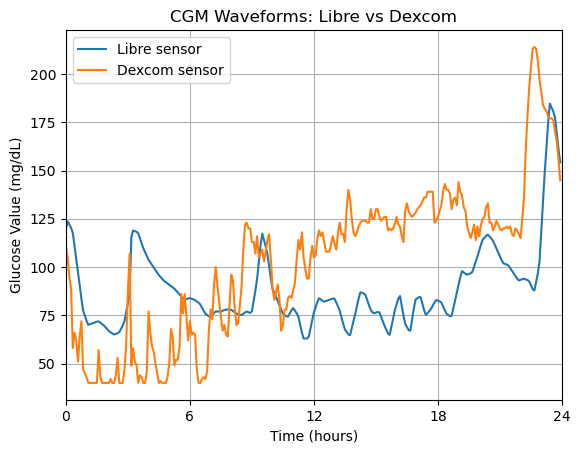

In [83]:

import numpy as np
import matplotlib.pyplot as plt

# Grab the 20th waveform from each sensor, first 24 hours (288 points)
i = 2
libre_wave  = df_cgm['Libre_CGM'].iloc[i][:288]
dexcom_wave = df_cgm['Dexcom_CGM'].iloc[i][:288]

# Create time axis in hours (5 minutes per sample, 288 samples = 24 hours)
time_hours = np.arange(288) * 5 / 60.0  # 0 to 24 hours

plt.plot(time_hours, libre_wave,  label="Libre sensor")   # blue
plt.plot(time_hours, dexcom_wave, label="Dexcom sensor")  # orange

plt.title("CGM Waveforms: Libre vs Dexcom")
plt.xlabel("Time (hours)")
plt.ylabel("Glucose Value (mg/dL)")
plt.xlim(0, 24)                     # force axis from 0 to 24
plt.xticks(np.arange(0, 25, 6))     # ticks every 6 hours
plt.legend()
plt.grid(True)
plt.show()

#df_cgm.head()
#df_cgm.isna()


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
test_dataset = CGMDataset(df_cgm, seq_col=cgm_data, label_col='diabetes_status', offset=0, mode=1, transform=None)
model = CNN1DBinaryClassifier()
state_dict = torch.load("best_model_cgm_cnn_week.pth")
model.load_state_dict(state_dict) 
model.to("cuda")


test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
probs, labels, loss = do_test(model, test_loader, criterion =nn.CrossEntropyLoss())
y_prob = np.array(probs)[:,1]   # predicted probabilities for class 1
y_true = np.array(labels, dtype=int)    # ground truth labels (0 or 1)

print_results(y_true, y_prob)
results_transformer = print_results(y_true, y_prob)
results_transformer['model'] = 'CNN1D_Week'
results_df = pd.DataFrame([results_transformer])

Accuracy: 0.7931034482758621
Balanced Accuracy: 0.7952380952380952

Confusion Matrix:
 [[11  4]
 [ 2 12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.73      0.79        15
           1       0.75      0.86      0.80        14

    accuracy                           0.79        29
   macro avg       0.80      0.80      0.79        29
weighted avg       0.80      0.79      0.79        29

F1 score 0.8
ROC AUC Score: 0.8381
AUPRC Score: 0.8318
Accuracy: 0.7931034482758621
Balanced Accuracy: 0.7952380952380952

Confusion Matrix:
 [[11  4]
 [ 2 12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.73      0.79        15
           1       0.75      0.86      0.80        14

    accuracy                           0.79        29
   macro avg       0.80      0.80      0.79        29
weighted avg       0.80      0.79      0.79        29

F1 score 0.8
ROC AUC Score: 0

In [85]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
test_dataset = CGMDataset(df_cgm, seq_col=cgm_data, label_col='diabetes_status', offset=0, mode=1, transform=None)

model = CGM2DCNN()
state_dict = torch.load("best_model_cgm2d_cnn_week.pth")
model.load_state_dict(state_dict) 
model.to("cuda")

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
probs, labels, loss = do_test(model, test_loader, criterion =nn.CrossEntropyLoss())
y_prob = np.array(probs)[:,1]   # predicted probabilities for class 1
y_true = np.array(labels, dtype=int)    # ground truth labels (0 or 1)

print_results(y_true, y_prob)
results_transformer = print_results(y_true, y_prob)
results_transformer['model'] = 'CNN2D_Week'
results_df = results_df._append(results_transformer, ignore_index=True)


Accuracy: 0.7241379310344828
Balanced Accuracy: 0.7261904761904762

Confusion Matrix:
 [[10  5]
 [ 3 11]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.69      0.79      0.73        14

    accuracy                           0.72        29
   macro avg       0.73      0.73      0.72        29
weighted avg       0.73      0.72      0.72        29

F1 score 0.7333333333333333
ROC AUC Score: 0.8286
AUPRC Score: 0.8242
Accuracy: 0.7241379310344828
Balanced Accuracy: 0.7261904761904762

Confusion Matrix:
 [[10  5]
 [ 3 11]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.69      0.79      0.73        14

    accuracy                           0.72        29
   macro avg       0.73      0.73      0.72        29
weighted avg       0.73      0.72      0.72        29

F1 score 0.733

In [86]:
prob_list = []
labels_list = []
model = CNN1DBinaryClassifier(num_classes=2)
state_dict = torch.load("best_model_cgm_cnn_day.pth")
model.load_state_dict(state_dict) 
model.to("cuda")
model.eval()
for i in range(7):
    test_dataset = CGMDataset(df_cgm, seq_col=cgm_data, label_col='diabetes_status', offset=i, mode=2, transform=None)

    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    probs, labels, loss = do_test(model, test_loader, criterion =nn.CrossEntropyLoss())
    
    prob_list.append(probs)   # Shape: (num_patients,) → each day = row
    labels_list.append(labels)  # Same shape

import numpy as np


# prob_list and labels_list are currently lists of arrays (len = 7)
# Stack them: shape (7, N) where N = number of patients
probs_all = np.stack(prob_list, axis=0)       # shape: (7, N, 2) if probs are softmax for both classes
labels_all = np.stack(labels_list, axis=0)    # shape: (7, N)


# If probs are 2D (N,2), we need column 1
if probs_all.ndim == 3:
    probs_all = probs_all[..., 1]   # shape (7, N)

print(probs_all.shape)
probs_all2 = probs_all
print(probs_all2.shape)
probs_max = probs_all2.mean(axis=0)   # shape (N,)

# All days should have the same labels, so just take the first
labels = labels_all[0]              # shape (N,)


results_transformer = print_results(labels, probs_max)
results_transformer['model'] = 'CNN1D_DAILY_MAX'
results_df = results_df._append(results_transformer, ignore_index=True)

(7, 29)
(7, 29)
Accuracy: 0.7241379310344828
Balanced Accuracy: 0.7333333333333334

Confusion Matrix:
 [[ 7  8]
 [ 0 14]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.47      0.64        15
         1.0       0.64      1.00      0.78        14

    accuracy                           0.72        29
   macro avg       0.82      0.73      0.71        29
weighted avg       0.82      0.72      0.70        29

F1 score 0.7777777777777778
ROC AUC Score: 0.8810
AUPRC Score: 0.8803


In [87]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
with open('random_forest_best.pkl', 'rb') as f:
    rf = pickle.load(f)
col='diabetes_status'
cols_to_drop=['patient_ids','diabetes_status']
X_test = df_cgm_stats.drop(columns=cols_to_drop)
y_test = df_cgm_stats[col]

print("Feature columns:", X_test.columns.tolist())



# ----- Predictions -----
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # Probability for positive class
results_transformer = print_results(y_true, y_prob)
results_transformer['model'] = 'rf_feature'
results_df = results_df._append(results_transformer, ignore_index=True)

Feature columns: ['spike_resolutions', 'expected_daily_spikes', 'mean_glucose', 'relative_spikes', 'hyper_time_pcts', 'nocturnal_hypoglycemias']
Accuracy: 0.7586206896551724
Balanced Accuracy: 0.7642857142857142

Confusion Matrix:
 [[ 9  6]
 [ 1 13]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.68      0.93      0.79        14

    accuracy                           0.76        29
   macro avg       0.79      0.76      0.75        29
weighted avg       0.80      0.76      0.75        29

F1 score 0.7878787878787878
ROC AUC Score: 0.8571
AUPRC Score: 0.8574


In [88]:
from model import CNN1DBinaryClassifier,TransformerFusion

#Finally get the test results
prob_list = []
labels_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN1DBinaryClassifier(num_classes=2)


fusion_model = TransformerFusion(cnn_model)
fusion_model = fusion_model.to(device)

fusion_model.load_state_dict(torch.load("best_model_cgm_transformer_week.pth"))

fusion_model.to("cuda")
fusion_model.eval()

test_dataset = CGMDataset(df_cgm, seq_col=cgm_data, label_col='diabetes_status', offset=0, mode=1, transform=None)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
probs, labels, loss  = do_test(fusion_model, test_loader, criterion =nn.CrossEntropyLoss())
# Convert to NumPy arrays
probs = np.vstack(probs)  # shape (N, 2)
labels = np.array([int(l.item()) for l in labels])  # shape (N,)

# Extract probability for the positive class (class 1)
y_prob = probs[:, 1]
y_true = labels

results_transformer = print_results(y_true, y_prob)
results_transformer['model'] = 'transformer'
results_df = results_df._append(results_transformer, ignore_index=True)





Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (1): ReLU()
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (3): ReLU()
  (4): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (5): ReLU()
  (6): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
  (7): ReLU()
  (8): Conv1d(256, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): ReLU()
  (10): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (11): ReLU()
  (12): Conv1d(512, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
  (13): ReLU()
  (14): AdaptiveAvgPool1d(output_size=1)
)
Accuracy: 0.7586206896551724
Balanced Accuracy: 0.7619047619047619

Confusion Matrix:
 [[10  5]
 [ 2 12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.71      0.86      0.77        14

    accuracy                           0.76        29
   macro avg    

In [16]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, balanced_accuracy_score, f1_score,
    precision_recall_curve, average_precision_score
)
X_test = test_dataset.X.squeeze()
y_test = test_dataset.y
with open("XGBoost_model.pkl", "rb") as f:
    best_pipeline = pickle.load(f)

# -----------------------------------------------------------
# Test evaluation
# -----------------------------------------------------------

y_test_pred = best_pipeline.predict(X_test)
y_test_prob = best_pipeline.predict_proba(X_test)[:, 1]

print("\n=== Test Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_prob))
print("AUPRC:", average_precision_score(y_test, y_test_prob))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

results_xgb = print_results(y_test, y_test_prob)
results_xgb['model'] = 'XGBoost_PCA'

results_df = results_df._append(results_xgb, ignore_index=True)



=== Test Metrics ===
Accuracy: 0.6896551724137931
Balanced Accuracy: 0.6833333333333333
Confusion Matrix:
 [[13  2]
 [ 7  7]]
F1: 0.6086956521739131
ROC AUC: 0.7523809523809525
AUPRC: 0.809368590346851

Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.87      0.74        15
         1.0       0.78      0.50      0.61        14

    accuracy                           0.69        29
   macro avg       0.71      0.68      0.68        29
weighted avg       0.71      0.69      0.68        29

Accuracy: 0.6896551724137931
Balanced Accuracy: 0.6833333333333333

Confusion Matrix:
 [[13  2]
 [ 7  7]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.87      0.74        15
         1.0       0.78      0.50      0.61        14

    accuracy                           0.69        29
   macro avg       0.71      0.68      0.68        29
weighted avg       0.71      0.69      0.6

In [17]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, balanced_accuracy_score, f1_score,
    precision_recall_curve, average_precision_score
)
X_test = test_dataset.X.squeeze()
y_test = test_dataset.y
with open("TABPFN_best_model.pkl", "rb") as f:
    saved = pickle.load(f)
best_model = saved["model"]
scaler = saved["scaler"]
pca = saved["pca"]

# Apply best preprocessing
X_test_scaled = scaler.transform(X_test)
X_test_pca    = pca.transform(X_test_scaled)

# Predictions
y_test_pred = best_model.predict(X_test_pca)
y_test_prob = best_model.predict_proba(X_test_pca)[:, 1]

# -----------------------------
# Final Test Metrics
# -----------------------------
print("\n=== Test Metrics ===")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

try:
    print("AUROC:", roc_auc_score(y_test, y_test_prob))
except:
    print("AUROC: Cannot compute (only one class present).")

print("AUPRC:", average_precision_score(y_test, y_test_prob))
print("F1:", f1_score(y_test, y_test_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

results_tab = print_results(y_test, y_test_prob)
results_tab['model'] = 'TABPFN_PCA'

results_df = results_df._append(results_tab, ignore_index=True)


=== Test Metrics ===
Balanced Accuracy: 0.6833333333333333
Accuracy: 0.6896551724137931
AUROC: 0.8285714285714286
AUPRC: 0.7986116264687693
F1: 0.6086956521739131

Confusion Matrix:
 [[13  2]
 [ 7  7]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.87      0.74        15
         1.0       0.78      0.50      0.61        14

    accuracy                           0.69        29
   macro avg       0.71      0.68      0.68        29
weighted avg       0.71      0.69      0.68        29

Accuracy: 0.6896551724137931
Balanced Accuracy: 0.6833333333333333

Confusion Matrix:
 [[13  2]
 [ 7  7]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.87      0.74        15
         1.0       0.78      0.50      0.61        14

    accuracy                           0.69        29
   macro avg       0.71      0.68      0.68        29
weighted avg       0.71      0.69      0.6

In [18]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, balanced_accuracy_score, f1_score,
    precision_recall_curve, average_precision_score
)
X_test = test_dataset.X.squeeze()
y_test = test_dataset.y
with open('RF_PCA_model.pkl', 'rb') as f:
    rf = pickle.load(f)

X_test = X_test#[:, :288]
print(X_test.shape)
y_test_pred = rf.predict(X_test)
y_test_prob = rf.predict_proba(X_test)[:, 1]

print("\nTest Metrics")
print(" AUC:", roc_auc_score(y_test, y_test_prob))
print(" Accuracy:", accuracy_score(y_test, y_test_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
auprc = average_precision_score(y_test, y_test_prob)
print(f"AUPRC Score: {auprc:.4f}")

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_test_pred))    
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("F1 score", f1_score(y_test, y_test_pred))
results_pca_rf = print_results(y_test, y_test_prob)
results_pca_rf['model'] = 'Random_Forest_PCA'
results_df = results_df._append(results_pca_rf, ignore_index=True)

torch.Size([29, 2016])

Test Metrics
 AUC: 0.8261904761904761
 Accuracy: 0.7241379310344828
 Confusion Matrix:
 [[ 8  7]
 [ 1 13]]
AUPRC Score: 0.8238
Balanced Accuracy: 0.730952380952381

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.53      0.67        15
         1.0       0.65      0.93      0.76        14

    accuracy                           0.72        29
   macro avg       0.77      0.73      0.72        29
weighted avg       0.77      0.72      0.71        29

F1 score 0.7647058823529411
Accuracy: 0.7241379310344828
Balanced Accuracy: 0.730952380952381

Confusion Matrix:
 [[ 8  7]
 [ 1 13]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.53      0.67        15
         1.0       0.65      0.93      0.76        14

    accuracy                           0.72        29
   macro avg       0.77      0.73      0.72        29
weighted avg       0.77      0

In [19]:
cols = ['model'] + [c for c in results_df.columns if c != 'model']
results_df = results_df[cols]

result_dir = r'C:\\Users\\preet\\Documents\\ai-readi-notebooks\\main\\CGM_diabetes_progression\\results2\\'
results_df.to_csv(result_dir+cgm_data+'_no_pretrn_Label_study_dataset_1_2_run_'+str(experiment_count)+'.csv')
results_df.head(16)

,model,AUC,AUPRC,Accuracy,BA,F1
0,CNN1D_Week,0.690476,0.781871,0.620690,0.619048,0.592593
1,CNN2D_Week,0.552381,0.669043,0.517241,0.514286,0.461538
2,CNN1D_DAILY_MAX,0.742857,0.795703,0.586207,0.592857,0.647059
3,rf_feature,0.692857,0.747485,0.551724,0.557143,0.606061
4,transformer,0.614286,0.622946,0.517241,0.526190,0.611111
5,XGBoost_PCA,0.752381,0.809369,0.689655,0.683333,0.608696
6,TABPFN_PCA,0.828571,0.798612,0.689655,0.683333,0.608696
7,Random_Forest_PCA,0.792857,0.827039,0.689655,0.688095,0.666667
8,XGBoost_PCA,0.752381,0.809369,0.689655,0.683333,0.608696
9,TABPFN_PCA,0.828571,0.798612,0.689655,0.683333,0.608696
